# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regurlar gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

For these exercises we will be working with the mnist_784 data set and a simple shallow neural network.  

First we need to get the data and define the network. We have done this part for you. 

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays
    # get number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])

    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will impletment plain old gradient descet. The mathmatical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ but feel free to play around with it. Also note that we are taking mini batches of the entire sample. 

In [2]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-4
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices and are numpy arrays.
        b1 and b2 are your bias for each matrix.
        """

        W1 -= eta * grad_W1
        W2 -= eta * grad_W2
        b1 -= eta * grad_b1
        b2 -= eta * grad_b2

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.298036 Accuracy 0.101714
Epoch 10 Loss 2.144243 Accuracy 0.604857
Epoch 20 Loss 1.909717 Accuracy 0.634857
Epoch 30 Loss 1.683711 Accuracy 0.675714
Epoch 40 Loss 1.489449 Accuracy 0.719429
Epoch 50 Loss 1.326372 Accuracy 0.770857
Epoch 60 Loss 1.189811 Accuracy 0.811429
Epoch 70 Loss 1.075225 Accuracy 0.839143
Epoch 80 Loss 0.978776 Accuracy 0.863143
Epoch 90 Loss 0.897173 Accuracy 0.876286
Epoch 100 Loss 0.827722 Accuracy 0.884286
Epoch 110 Loss 0.768145 Accuracy 0.891714
Epoch 120 Loss 0.716710 Accuracy 0.897143
Epoch 130 Loss 0.671973 Accuracy 0.898571
Epoch 140 Loss 0.632738 Accuracy 0.900571
Epoch 150 Loss 0.598135 Accuracy 0.903714
Epoch 160 Loss 0.567441 Accuracy 0.902857
Epoch 170 Loss 0.539933 Accuracy 0.905143
Epoch 180 Loss 0.515336 Accuracy 0.905714
Epoch 190 Loss 0.493007 Accuracy 0.906571
Epoch 200 Loss 0.472826 Accuracy 0.907714
Epoch 210 Loss 0.454425 Accuracy 0.909429
Epoch 220 Loss 0.437605 Accuracy 0.910000
Epoch 230 Loss 0.422133 Accuracy 0.910857
Epo

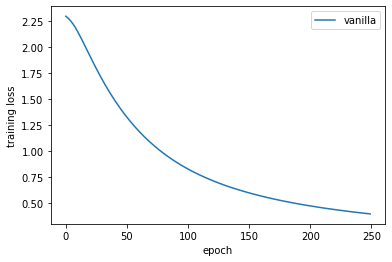

In [4]:
import matplotlib.pyplot as plt

plt.plot(vanilla_loss, label='vanilla')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The mathmatical formula is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [5]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-4
initial_batch_size = 104
epochs = 250
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""
Beta_1 = 0.9

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
momentum_loss = []

"""
You probably need to initialize your momentum here... 
"""
W1_m = np.zeros((n_0, n_1))
W2_m = np.zeros((n_1, N))
b1_m = np.zeros((1, n_1))
b2_m = np.zeros((1, N))

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices,.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        W1_m = W1_m * Beta_1 + (1 - Beta_1) * grad_W1
        W2_m = W2_m * Beta_1 + (1 - Beta_1) * grad_W2
        b1_m = b1_m * Beta_1 + (1 - Beta_1) * grad_b1
        b2_m = b2_m * Beta_1 + (1 - Beta_1) * grad_b2
        W1 -= eta * W1_m
        W2 -= eta * W2_m
        b1 -= eta * b1_m
        b2 -= eta * b2_m

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.298872 Accuracy 0.101714
Epoch 10 Loss 2.148456 Accuracy 0.605429
Epoch 20 Loss 1.915077 Accuracy 0.635143
Epoch 30 Loss 1.688630 Accuracy 0.674286
Epoch 40 Loss 1.493597 Accuracy 0.718571
Epoch 50 Loss 1.329790 Accuracy 0.769143
Epoch 60 Loss 1.192592 Accuracy 0.810571
Epoch 70 Loss 1.077446 Accuracy 0.838286
Epoch 80 Loss 0.980566 Accuracy 0.862000
Epoch 90 Loss 0.898588 Accuracy 0.876571
Epoch 100 Loss 0.828850 Accuracy 0.884286
Epoch 110 Loss 0.769051 Accuracy 0.891429
Epoch 120 Loss 0.717415 Accuracy 0.897143
Epoch 130 Loss 0.672558 Accuracy 0.898571
Epoch 140 Loss 0.633188 Accuracy 0.900571
Epoch 150 Loss 0.598470 Accuracy 0.903714
Epoch 160 Loss 0.567681 Accuracy 0.904000
Epoch 170 Loss 0.540132 Accuracy 0.905714
Epoch 180 Loss 0.515456 Accuracy 0.905429
Epoch 190 Loss 0.493101 Accuracy 0.907429
Epoch 200 Loss 0.472867 Accuracy 0.908286
Epoch 210 Loss 0.454465 Accuracy 0.908571
Epoch 220 Loss 0.437572 Accuracy 0.910000
Epoch 230 Loss 0.422090 Accuracy 0.911143
Epo

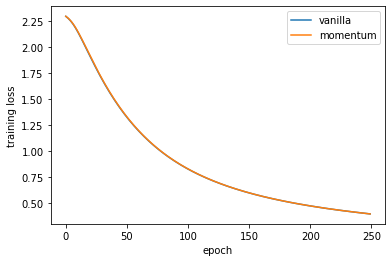

In [6]:
plt.plot(vanilla_loss, label='vanilla')
plt.plot(momentum_loss, label='momentum')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

# RMSProp Gradient Descent 

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [7]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-4
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""
Beta_2 = 0.9
epsilon = 1e-8

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
W1_v = np.zeros((n_0, n_1))
W2_v = np.zeros((n_1, N))
b1_v = np.zeros((1, n_1))
b2_v = np.zeros((1, N))

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices,.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        W1_v = W1_v * Beta_2 + (1 - Beta_2) * grad_W1 * grad_W1
        W2_v = W2_v * Beta_2 + (1 - Beta_2) * grad_W2 * grad_W2
        b1_v = b1_v * Beta_2 + (1 - Beta_2) * grad_b1 * grad_b1
        b2_v = b2_v * Beta_2 + (1 - Beta_2) * grad_b2 * grad_b2
        W1 -= eta * grad_W1 / np.sqrt(W1_v + epsilon)
        W2 -= eta * grad_W2 / np.sqrt(W2_v + epsilon)
        b1 -= eta * grad_b1 / np.sqrt(b1_v + epsilon)
        b2 -= eta * grad_b2 / np.sqrt(b2_v + epsilon)


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 1.476090 Accuracy 0.854286
Epoch 10 Loss 0.182095 Accuracy 0.923714
Epoch 20 Loss 0.093373 Accuracy 0.932286
Epoch 30 Loss 0.062008 Accuracy 0.930857
Epoch 40 Loss 0.042053 Accuracy 0.937714
Epoch 50 Loss 0.031849 Accuracy 0.938857
Epoch 60 Loss 0.026057 Accuracy 0.940571
Epoch 70 Loss 0.020526 Accuracy 0.942000
Epoch 80 Loss 0.018287 Accuracy 0.940286
Epoch 90 Loss 0.018672 Accuracy 0.938857
Epoch 100 Loss 0.015420 Accuracy 0.942286
Epoch 110 Loss 0.013094 Accuracy 0.936286
Epoch 120 Loss 0.016157 Accuracy 0.940571
Epoch 130 Loss 0.013928 Accuracy 0.943429
Epoch 140 Loss 0.011198 Accuracy 0.946286
Epoch 150 Loss 0.009934 Accuracy 0.941429
Epoch 160 Loss 0.009301 Accuracy 0.946857
Epoch 170 Loss 0.008197 Accuracy 0.945143
Epoch 180 Loss 0.007610 Accuracy 0.950571
Epoch 190 Loss 0.008163 Accuracy 0.946571
Epoch 200 Loss 0.018717 Accuracy 0.946857
Epoch 210 Loss 0.007316 Accuracy 0.951429
Epoch 220 Loss 0.015982 Accuracy 0.945429
Epoch 230 Loss 0.006660 Accuracy 0.954000
Epo

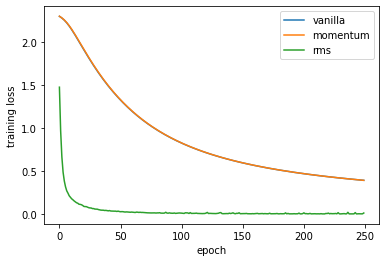

In [8]:
plt.plot(vanilla_loss, label='vanilla')
plt.plot(momentum_loss, label='momentum')
plt.plot(RMS_loss, label='rms')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

# Adam Gradient Descent 

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

In [9]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-4
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
Beta_1 = 0.9
Beta_2 = 0.9
epsilon = 1e-8

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""
W1_m = np.zeros((n_0, n_1))
W2_m = np.zeros((n_1, N))
b1_m = np.zeros((1, n_1))
b2_m = np.zeros((1, N))

W1_v = np.zeros((n_0, n_1))
W2_v = np.zeros((n_1, N))
b1_v = np.zeros((1, n_1))
b2_v = np.zeros((1, N))

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices,.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        W1_m = W1_m * Beta_1 + (1 - Beta_1) * grad_W1
        W2_m = W2_m * Beta_1 + (1 - Beta_1) * grad_W2
        b1_m = b1_m * Beta_1 + (1 - Beta_1) * grad_b1
        b2_m = b2_m * Beta_1 + (1 - Beta_1) * grad_b2
        
        W1_v = W1_v * Beta_2 + (1 - Beta_2) * grad_W1 * grad_W1
        W2_v = W2_v * Beta_2 + (1 - Beta_2) * grad_W2 * grad_W2
        b1_v = b1_v * Beta_2 + (1 - Beta_2) * grad_b1 * grad_b1
        b2_v = b2_v * Beta_2 + (1 - Beta_2) * grad_b2 * grad_b2

        W1_m_hat = W1_m / (1 - np.power(Beta_1, i*num_batches + j+1))
        W2_m_hat = W2_m / (1 - np.power(Beta_1, i*num_batches + j+1))
        b1_m_hat = b1_m / (1 - np.power(Beta_1, i*num_batches + j+1))
        b2_m_hat = b2_m / (1 - np.power(Beta_1, i*num_batches + j+1))

        W1_v_hat = W1_v / (1 - np.power(Beta_2, i*num_batches + j+1))
        W2_v_hat = W2_v / (1 - np.power(Beta_2, i*num_batches + j+1))
        b1_v_hat = b1_v / (1 - np.power(Beta_2, i*num_batches + j+1))
        b2_v_hat = b2_v / (1 - np.power(Beta_2, i*num_batches + j+1))

        W1 -= eta * W1_m_hat / np.sqrt(W1_v_hat + epsilon)
        W2 -= eta * W2_m_hat / np.sqrt(W2_v_hat + epsilon)
        b1 -= eta * b1_m_hat / np.sqrt(b1_v_hat + epsilon)
        b2 -= eta * b2_m_hat / np.sqrt(b2_v_hat + epsilon)

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 1.558849 Accuracy 0.850000
Epoch 10 Loss 0.168466 Accuracy 0.924571
Epoch 20 Loss 0.086542 Accuracy 0.934857
Epoch 30 Loss 0.054688 Accuracy 0.934571
Epoch 40 Loss 0.036523 Accuracy 0.938571
Epoch 50 Loss 0.027591 Accuracy 0.940571
Epoch 60 Loss 0.021627 Accuracy 0.942000
Epoch 70 Loss 0.019748 Accuracy 0.943143
Epoch 80 Loss 0.014321 Accuracy 0.941143
Epoch 90 Loss 0.012424 Accuracy 0.943714
Epoch 100 Loss 0.012040 Accuracy 0.946571
Epoch 110 Loss 0.012027 Accuracy 0.946857
Epoch 120 Loss 0.010371 Accuracy 0.946571
Epoch 130 Loss 0.010606 Accuracy 0.944000
Epoch 140 Loss 0.009115 Accuracy 0.950571
Epoch 150 Loss 0.008804 Accuracy 0.948000
Epoch 160 Loss 0.008574 Accuracy 0.947714
Epoch 170 Loss 0.008073 Accuracy 0.950000
Epoch 180 Loss 0.008795 Accuracy 0.948286
Epoch 190 Loss 0.010239 Accuracy 0.952857
Epoch 200 Loss 0.008727 Accuracy 0.952286
Epoch 210 Loss 0.009866 Accuracy 0.951143
Epoch 220 Loss 0.007818 Accuracy 0.956286
Epoch 230 Loss 0.008486 Accuracy 0.952571
Epo

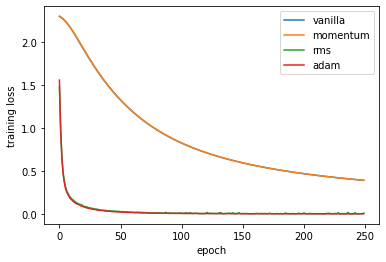

In [10]:
plt.plot(vanilla_loss, label='vanilla')
plt.plot(momentum_loss, label='momentum')
plt.plot(RMS_loss, label='rms')
plt.plot(Adam_loss, label='adam')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()